#Importing Libraries

In [30]:
import re, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
import keras.backend as K
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model, Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D, GRU
from keras.initializers import Constant
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from mlxtend.plotting import plot_confusion_matrix

#Downloading some packages

In [31]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

#Creating the model

Files 'spam.csv' and 'glove.6B.50d.txt' are uploaded to the path: '/content/'

In [32]:
class CustomHyperParameters():
  MAX_SEQUENCE_LEN = 22 
  BATCH_SIZE = 32
  NUM_EPOCHS = 8 
  LEARNING_RATE = 1e-4
  EMBEDDING_DIMENSIONS = 50 
  FILE_NAME = 'spam.csv'
  CSV_FILE_LOCATION = "/content/" + FILE_NAME
  MODEL_NAME = 'SpamModel.h5'
  H5_MODEL_LOCATION = "/content/" + MODEL_NAME


####Twitter dataset

File 'train.csv' is uploaded to the path: 'content/'

In [33]:
class CustomDataLoader():

  def __init__(self):
    self.customHyperParameters = CustomHyperParameters()
    self.df = self.loading_into_dataframe()

  def loading_into_dataframe(self):
    whole_data_into_dataframe = pd.read_csv('train.csv', encoding = "ISO-8859-1")
    whole_data_into_dataframe.rename({'Tweet': 'v1', 'Type': 'v2'}, axis=1, inplace=True)
    whole_data_into_dataframe['v2']=whole_data_into_dataframe['v2'].replace({'Quality':0,'Spam':1})
    whole_data_into_dataframe.rename({'v2': 'spam_labels', 'v1': 'text_messages'}, axis=1, inplace=True)
    return whole_data_into_dataframe[['spam_labels', 'text_messages']]
    
if __name__ == '__main__':
  p = CustomDataLoader()
  print(p.df['spam_labels'])
#Best results for the Twitter dataset are given with batch size==12!

0        0
1        1
2        0
3        0
4        0
        ..
14894    1
14895    0
14896    1
14897    0
14898    1
Name: spam_labels, Length: 14899, dtype: object


In [34]:
#Test score with the orginal data >>> around 0.92
#Test score with Twitter data >>> around 0.90

####Original Dataset

There are 5573 records in the original dataset.

There are 9308 records in the augmented orginal dataset.

In [35]:
class CustomDataLoader():

  def __init__(self):
    self.customHyperParameters = CustomHyperParameters()
    self.df = self.loading_into_dataframe()

  def loading_into_dataframe(self):
    whole_data_into_dataframe = pd.read_csv(self.customHyperParameters.CSV_FILE_LOCATION, encoding = "ISO-8859-1")
    sliced_df = whole_data_into_dataframe.iloc[:,:2]
    sliced_df['v1']=sliced_df['v1'].replace({'ham':0,'spam':1})
    sliced_df.rename({'v1': 'spam_labels', 'v2': 'text_messages'}, axis=1, inplace=True)
    return sliced_df
    
if __name__ == '__main__':
  p = CustomDataLoader()
  print(p.df)

      spam_labels                                      text_messages
0               0  Go until jurong point, crazy.. Available only ...
1               0                      Ok lar... Joking wif u oni...
2               1  Free entry in 2 a wkly comp to win FA Cup fina...
3               0  U dun say so early hor... U c already then say...
4               0  Nah I don't think he goes to usf, he lives aro...
...           ...                                                ...
9302            1  want for sex in 30 moments? ring 6 ÃÂª! 0 20p...
9303            1  opt in if its chatlines inclu to 30 mins. indi...
9304            1  had any contract mobile been answered? nokia m...
9305            1  follow this me : to get 2. 50 pounds free call...
9306            1  this was his 2nd time we have tried directly c...

[9307 rows x 2 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
class CustomTokenizer():
  def __init__(self):
    self.customHyperParameters = CustomHyperParameters()
    self.customDataLoader = CustomDataLoader()
    self.tokenizer_object = Tokenizer()

    self.corpus = self.create_corpus()
    self.fitting_the_Tokizer()

  def create_corpus(self):
    df = self.customDataLoader.df
    dataframe_as_list = pd.Series.tolist(df['text_messages'])
    corpus = []
    for el in dataframe_as_list:
      text = re.sub('[^a-zA-Z]', ' ', el)  
      text = text.lower() 
      text = [w for w in word_tokenize(text)]
      text = [w for w in text if not w in set(stopwords.words('english')) and w.isalpha()] 
      corpus.append(text)
    return corpus

  def fitting_the_Tokizer(self):
    self.tokenizer_object.fit_on_texts(self.corpus)

  def tokenize_and_pad(self, dataToBeTokenized):
    sequences=self.tokenizer_object.texts_to_sequences(dataToBeTokenized)
    tweet_pad=pad_sequences(sequences,maxlen=self.customHyperParameters.MAX_SEQUENCE_LEN,truncating='post',padding='post')
    return tweet_pad
  
  def get_the_number_of_words(self):
    word_index=CustomTokenizer().tokenizer_object.word_index
    num_words=len(word_index)+1
    return (word_index, num_words)

In [37]:
class CustomEmbeddings():
  FILE_NAME = 'glove.6B.50d.txt'
  CSV_FILE_LOCATION = "/content/" + FILE_NAME

  def __init__(self):
    self.customHyperParameters = CustomHyperParameters()
    self.tokenizer_obj = CustomTokenizer()

    self.dict_with_embeddings = self.creating_embedding_dict()
    
  def creating_embedding_dict(self):
    dict_with_embeddings={}
    with open(CustomEmbeddings.CSV_FILE_LOCATION,'r') as f:
      for line in f:
        values = line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        dict_with_embeddings[word]=vectors
    return dict_with_embeddings

  def creating_embedding_matrix(self):
    word_index, num_words=self.tokenizer_obj.get_the_number_of_words()
    embedding_matrix=np.zeros((num_words,self.customHyperParameters.EMBEDDING_DIMENSIONS))
    for word,i in tqdm(word_index.items()):
        emb_vec=self.dict_with_embeddings.get(word)
        if emb_vec is not None:
            embedding_matrix[i]=emb_vec
    return embedding_matrix

In [38]:
class CustomDataSplitter():
  def __init__(self):
    self.customDataLoader = CustomDataLoader()
    self.customTokenizer = CustomTokenizer()
    self.padded_data = self.customTokenizer.tokenize_and_pad(self.customTokenizer.corpus)

    self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test = self.splitting_the_data(self.padded_data, self.customDataLoader.df.spam_labels.values)

  def splitting_the_data(self, padded_text, labels):
    padded_text = np.asarray(padded_text).astype(np.int32)
    labels = np.asarray(labels).astype(np.int32)
    X_train, X_val_and_test, y_train, y_val_and_test = train_test_split(padded_text,labels, test_size=.3, random_state=2)
    X_val, X_test, y_val, y_test = train_test_split(X_val_and_test,y_val_and_test, test_size=.33, random_state=2)

    print('Shape of train sequences: ',X_train.shape)
    print("Shape of Validation sequences: ",X_val.shape)
    print("Shape of Test sequences: ",X_test.shape)
    print('Shape of train labels: ',y_train.shape)
    print("Shape of Validation  labels: ",y_val.shape)
    print("Shape of Test  labels: ",y_test.shape)

    return X_train, X_val, X_test, y_train, y_val, y_test 

In [39]:
def finding_true_positives_as_percent(y_true, y_pred):
  y_pred, y_true = converting_the_values(y_true, y_pred)  
  indexes_of_true_values = tf.where(y_true == 1)
  selected_actual_value = tf.gather_nd( y_true, indexes_of_true_values,) 
  selected_predicted_value = tf.gather_nd(y_pred, indexes_of_true_values,) 
  true_positives_percent = finding_the_metric(selected_actual_value, selected_predicted_value)
  return true_positives_percent

def finding_true_negatives_as_percent(y_true, y_pred):
  y_pred, y_true = converting_the_values(y_true, y_pred)  
  indexes_of_true_values = tf.where(y_true != 1)
  selected_actual_value = tf.gather_nd( y_true, indexes_of_true_values,) 
  selected_predicted_value = tf.gather_nd(y_pred, indexes_of_true_values,) 
  true_negatives_percent = finding_the_metric(selected_actual_value, selected_predicted_value)
  return true_negatives_percent

def finding_false_positives_as_percent(y_true, y_pred):
  y_pred, y_true = converting_the_values(y_true, y_pred)  
  indexes_of_false_values = tf.where(y_true == 1)
  selected_actual_value = tf.gather_nd(y_true, indexes_of_false_values,) 
  selected_predicted_value = tf.gather_nd((1 - y_pred), indexes_of_false_values,) 
  false_positives_percent = finding_the_metric(selected_actual_value, selected_predicted_value)
  return false_positives_percent

def finding_false_negatives_as_percent(y_true, y_pred):
  y_pred, y_true = converting_the_values(y_true, y_pred)  
  indexes_of_false_values = tf.where(y_true != 1)
  selected_actual_value = tf.gather_nd(y_true, indexes_of_false_values,) 
  selected_predicted_value = tf.gather_nd((1 - y_pred), indexes_of_false_values,) 
  false_negatives_percent = finding_the_metric(selected_actual_value, selected_predicted_value)
  return false_negatives_percent

def converting_the_values(y_true, y_pred):
  y_pred = K.round(y_pred)
  y_pred = tf.dtypes.cast(y_pred, tf.int32)
  y_true = tf.dtypes.cast(y_true, tf.int32)
  return y_pred, y_true

def finding_the_metric(selected_actual_value, selected_predicted_value):
  comparing_the_2_values = tf.math.equal(selected_actual_value, selected_predicted_value)
  casted_values = tf.dtypes.cast(comparing_the_2_values, tf.float64)
  metric = tf.reduce_mean(casted_values)
  return metric

def custom_f1_score(y_true, y_pred):
  precision, recall = finding_precision_and_recall(y_true, y_pred)

  custom_f1_score = 2 * (precision * recall)/(precision + recall + K.epsilon())
  f1 = tf.where(tf.math.is_nan(custom_f1_score), tf.zeros_like(custom_f1_score), custom_f1_score)
  return  tf.keras.backend.mean(f1)

def custom_f_0_point_8_score(y_true, y_pred):
  precision, recall = finding_precision_and_recall(y_true, y_pred)

  custom_f_0_point_8_score = (1+0.8**2) * (precision * recall)/((precision* 0.8**2) + recall + K.epsilon()) 
  f1 = tf.where(tf.math.is_nan(custom_f_0_point_8_score), tf.zeros_like(custom_f_0_point_8_score), custom_f_0_point_8_score)
  return  tf.keras.backend.mean(f1)

def finding_precision_and_recall(y_true, y_pred):
  true_positive = finding_true_positives_as_percent(y_true, y_pred)
  true_negative = finding_true_negatives_as_percent(y_true, y_pred)
  false_positive = finding_false_positives_as_percent(y_true, y_pred)
  false_negative = finding_false_negatives_as_percent(y_true, y_pred)

  precision = true_positive/ (true_positive + false_positive + K.epsilon())
  recall =  true_positive /(true_positive + false_negative + K.epsilon())

  return precision, recall

#Actual and Predicted 1 = TP
#Actual and Predicted 0 = TN
#Actual 1, Predicted 0 = FP = For Precision
#Actual 0, Predicted 1 = FN = For Recall

In [40]:
class SpamModel():

  def __init__(self):
    self.customHyperParameters = CustomHyperParameters()
    self.dataSplitter = CustomDataSplitter()
    self.embeddings = CustomEmbeddings()
    self.tokenizer_obj = CustomTokenizer()

    self.already_fine_tuned()

  def already_fine_tuned(self):
    if os.path.exists(self.customHyperParameters.H5_MODEL_LOCATION):
      self.loading_the_model()
    else:
      self.running_the_model()
      self.saving_the_model()

  def saving_the_model(self):
    self.model.save(filepath = self.customHyperParameters.H5_MODEL_LOCATION,  overwrite=True, include_optimizer=True)

  def loading_the_model(self):
    self.model = load_model(filepath = self.customHyperParameters.H5_MODEL_LOCATION, custom_objects= {'custom_f1_score': custom_f1_score, 'custom_f_0_point_8_score' : custom_f_0_point_8_score})
    self.model.summary()

  def running_the_model(self):
    _, num_words=self.tokenizer_obj.get_the_number_of_words()
    self.embedding_matrix = self.embeddings.creating_embedding_matrix()
    self.model = self.defining_model_architecture(num_words, self.customHyperParameters.MAX_SEQUENCE_LEN, self.embedding_matrix)
    self.defining_a_compiler()
    self.fitting_the_model(self.dataSplitter.X_train, self.dataSplitter.y_train, self.dataSplitter.X_val, self.dataSplitter.y_val,)
    self.evaluating_the_model(self.dataSplitter.X_test, self.dataSplitter.y_test)
    self.vizualizing_confusion_matrix(self.dataSplitter.X_test, self.dataSplitter.y_test)
    self.making_of_roc_curve(self.dataSplitter.X_test, self.dataSplitter.y_test)

  def defining_model_architecture(self, NUM_WORDS, MAX_LEN, embedding_matrix):
    model=Sequential()
    embedding_layer=Embedding(NUM_WORDS,self.customHyperParameters.EMBEDDING_DIMENSIONS,embeddings_initializer=Constant(embedding_matrix),
                      input_length=MAX_LEN,trainable=False)
    model.add(embedding_layer)
    model.add(SpatialDropout1D(0.2))
    model.add(GRU(64, dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
    model.add(tf.keras.layers.GRU(32,return_sequences=True))
    model.add(tf.keras.layers.GRU(16))
    model.add(tf.keras.layers.Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

  def defining_a_compiler(self):
    optimzer=Adam(learning_rate=self.customHyperParameters.LEARNING_RATE)
    self.model.compile(loss='binary_crossentropy',optimizer=optimzer,metrics=['acc', custom_f1_score, custom_f_0_point_8_score, tf.keras.metrics.AUC()])
    self.model.summary()

  def fitting_the_model(self, X_train, y_train, X_val, y_val):
    self.model.fit(X_train,y_train,batch_size=self.customHyperParameters.BATCH_SIZE,epochs=self.customHyperParameters.NUM_EPOCHS,validation_data=(X_val,y_val),verbose=1)

  def evaluating_the_model(self, X_test, y_test):
    eval_metric = self.model.evaluate(x =X_test , y = y_test, batch_size =self.customHyperParameters.BATCH_SIZE , verbose=1, )
    print(f'Performance of the Test set: {eval_metric}')

  def making_predictions(self, iterator_with_messages_to_be_predicted):
    prediction = self.model.predict(x = iterator_with_messages_to_be_predicted, verbose=0,)
    return prediction

  def vizualizing_confusion_matrix(self, y_to_be_predicted, y_true): 
    predictions = self.making_predictions(y_to_be_predicted)
    y_pred = predictions > 0.5
    data = confusion_matrix(y_true, y_pred)
    print(data)
    fig, ax = plot_confusion_matrix(conf_mat=data,
                                    show_absolute=True,
                                    show_normed=True,
                                    colorbar=True,
                                    cmap = 'cool',
                                    figsize = (10, 7))
    plt.show()

  def making_of_roc_curve(self,y_to_be_predicted, y_true): 
    predictions = self.making_predictions(y_to_be_predicted)
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(y_true, predictions)
    print('roc_auc_score for SpamModel: ', roc_auc_score(y_true, predictions)) 
    
    plt.subplots(1, figsize=(10,10))
    plt.title('Receiver Operating Characteristic - SpamModel')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


#RUNNING THE MODEL

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Shape of train sequences:  (6514, 22)
Shape of Validation sequences:  (1871, 22)
Shape of Test sequences:  (922, 22)
Shape of train labels:  (6514,)
Shape of Validation  labels:  (1871,)
Shape of Test  labels:  (922,)


100%|██████████| 9914/9914 [00:00<00:00, 601561.39it/s]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 22, 50)            495750    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 22, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 22, 64)            22272     
_________________________________________________________________
gru_4 (GRU)                  (None, 22, 32)            9408      
_________________________________________________________________
gru_5 (GRU)                  (None, 16)                2400      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

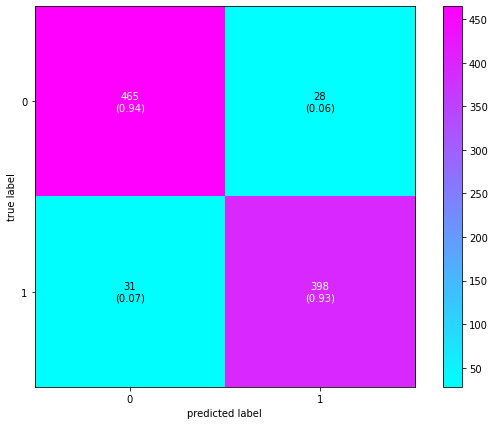

roc_auc_score for SpamModel:  0.9806474796332808


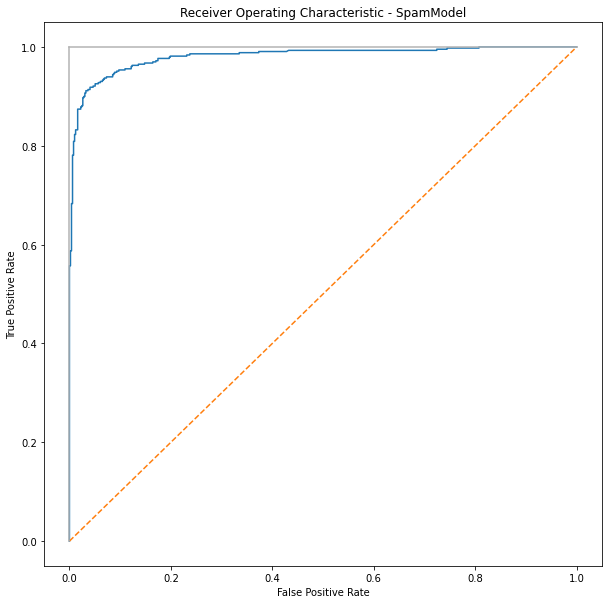

In [41]:
spamModel = SpamModel() 

#How well our model makes predictions

Predictions on selfmade examples

In [42]:
#Examples of Spam and non-Spam messages:
spam_messages_list = ['Hello. We detected fraudulent activity on your Apple iCloud account. To reset password www.applesupport/1234ds.com',
                      'You received 3 bitcoins($14,242 USD) in your account. Register to accept the transfer: https://bitcoinmine/232qq.com',
                      'DSK BANK: Your account is temporary locked. Please log in at https://dskbank/support/verification.bg to verify that its you.',
                      'Congratulations! You are the 1000 user registered to https://ifeelhappy.com and you win 10 000 $. Log in to https://ifeelhappy.com to claim your reward.']
spam_messages_labels = [1,1,1,1]
non_spam_messages_list = ["Hello Ivan, it's me - Nataly. Could you return me the books i borrowed you last week?",
                          'hi, nice to meet you, how are u? watcha you doin?',
                          "I am telling you Gerasim is a liar, believe me, dont trust him and go get your documents at 5 i'clock",
                          'Heheheh, that was a nice joke, i would remember it and keep on laughting at it for weeks, xaxaxaxaaxa :D:D:D::d']
non_spam_messages_labels = [0,0,0,0]
all_examples = spam_messages_list + non_spam_messages_list
all_examples_labels =  spam_messages_labels + non_spam_messages_labels

In [43]:
#Predictions on both spam and nonspam
temp_tokenizer = CustomTokenizer()
padded_data = temp_tokenizer.tokenize_and_pad(all_examples)
spamModel.making_predictions(padded_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


array([[0.956008  ],
       [0.9736974 ],
       [0.9611976 ],
       [0.97931004],
       [0.16661088],
       [0.03164054],
       [0.03788686],
       [0.03104663]], dtype=float32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


[[4 0]
 [0 4]]


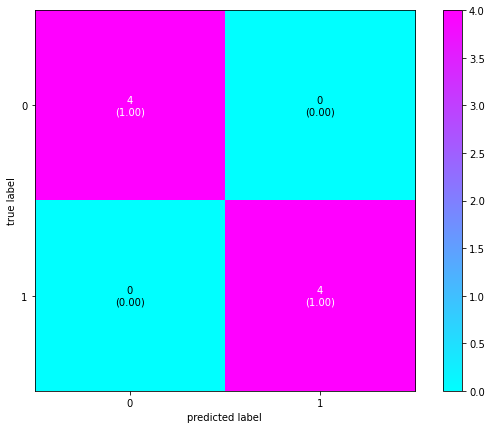

In [44]:
#Confusion matrix on both spam and non_spam messages
temp_tokenizer = CustomTokenizer()
padded_data = temp_tokenizer.tokenize_and_pad(all_examples)
spamModel.vizualizing_confusion_matrix(padded_data, np.array(all_examples_labels))

# Creating some basic models

In [63]:
"""
1.Naive Bayes
2.Logistic regression, SVM and Random Forest
3.K-Nearest Neighbours, Decision Tree,  Stochastic Gradient Descent, Linear Discriminant Analysis',
"""

"\n1.Naive Bayes\n2.Logistic regression, SVM and Random Forest\n3.K-Nearest Neighbours, Decision Tree,  Stochastic Gradient Descent, Linear Discriminant Analysis',\n"

In [64]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC 
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [65]:
all_models = {
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(),
    'Stochastic Gradient Descent': SGDClassifier(), 
    'K-Nearest Neighbours': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(), 
    'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
}

###Training and Test data:

In [66]:
dataSplitter = CustomDataSplitter()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Shape of train sequences:  (6514, 22)
Shape of Validation sequences:  (1871, 22)
Shape of Test sequences:  (922, 22)
Shape of train labels:  (6514,)
Shape of Validation  labels:  (1871,)
Shape of Test  labels:  (922,)


In [67]:
x_train, y_train = dataSplitter.X_train, dataSplitter.y_train
x_test, y_test = dataSplitter.X_test, dataSplitter.y_test

###Fitting the models

In [68]:
scores = {}

for model_name, model in all_models.items():
  model.fit(x_train, y_train)
  y_pred = model.predict(x_test)
  y_true = y_test
  score = custom_f1_score(y_true, y_pred).numpy()
  scores[model_name] = score

###Classification model scores on the test set:

In [69]:
scores

{'Decision Tree': 0.8426966818878634,
 'K-Nearest Neighbours': 0.769093272084822,
 'LinearDiscriminantAnalysis': 0.640420940276102,
 'Logistic Regression': 0.6904963645982914,
 'Naive Bayes': 0.4923229454050911,
 'Random Forest': 0.8814391301706401,
 'Stochastic Gradient Descent': 0.6690533246585143,
 'Support Vector Machine': 0.7981211602373682}

In [52]:
#Best basic model score >>> 'Random Forest': 0.8911041777767262

In [53]:
#ANN score:  0.9382990002632141. That's the best score so far!

#Creating a T5 Model

##Installation

In [54]:
!pip install simpletransformers
!pip install tokenizers==0.9.4

##Importing libraries

In [55]:
import json
import numpy as np
import pandas as pd
from datetime import datetime
from pprint import pprint
from simpletransformers.t5 import T5Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

##Preparing the data for training

In [56]:
class CustomDataPreprocessor():
  FILE_NAME = 'spam.csv'

  def __init__(self):
    self.train_df, self.eval_df, self.test_df = self.spliting_into_train_dev_test()

  def spliting_into_train_dev_test(self):
    whole_df = self.data_ingestion()

    train, test = train_test_split(whole_df, test_size=.3, random_state=2)
    eval, test = train_test_split(test, test_size=.3, random_state=2)

    return self.reseting_the_index(train),self.reseting_the_index(eval), self.reseting_the_index(test)

  def data_ingestion(self):
    df = pd.read_csv(CustomDataPreprocessor.FILE_NAME, encoding='latin-1',)
    sliced_df = df.iloc[:,:2]
    sliced_df['v1']=sliced_df['v1'].replace({'ham':0,'spam':1})
    sliced_df = self.preprocessing_the_dataframe(sliced_df)

    return sliced_df

  def preprocessing_the_dataframe(self, df):
    df = pd.DataFrame({
    'prefix': ["binary classification" for i in range(len(df))],
    'input_text': df['v2'],
    'target_text': df['v1'].astype(str),
    })
    return df

  def reseting_the_index(self, df):
    df = df.reset_index(drop=True)
    return df
    

p = CustomDataPreprocessor()
p.train_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,prefix,input_text,target_text
0,binary classification,Would you dislike to see my XXX pics they diff...,1
1,binary classification,Urgent UR awarded a uncomplimentary trip to Eu...,1
2,binary classification,Customer service announcement. We recently tri...,1
3,binary classification,Haiyoh... Maybe your hamster was jealous of mi...,0
4,binary classification,"Thanks for your time again, reference of X29. ...",1
...,...,...,...
6509,binary classification,Been up to ne thing interesting. Did you have ...,0
6510,binary classification,Ok ill send you with in &lt;DECIMAL&gt; ok.,0
6511,binary classification,< Forwarded from 21870000> Hi - this differ yo...,1
6512,binary classification,Now thats going to ruin your thesis!,0


##Creating and training the model

In [57]:
class CustomT5Model():
  MODEL_ARGS = {
    "max_seq_length": 196,
    "train_batch_size": 8,
    "eval_batch_size": 8,
    "num_train_epochs": 1,
    "evaluate_during_training": True,
    "evaluate_during_training_steps": 15000, 
    "evaluate_during_training_verbose": True,
    
    "use_multiprocessing": False,
    "fp16": False,

    "save_steps": -1,
    "save_eval_checkpoints": False,
    "save_model_every_epoch": False,

    "reprocess_input_data": True,
    "overwrite_output_dir": True,
  }

  def __init__(self):
    self.customDataPreprocessor = CustomDataPreprocessor()
    self.model = self.creating_a_t5_model()
    self.t5_train()

  def creating_a_t5_model(self):
    model = T5Model("t5", "t5-base", args=CustomT5Model.MODEL_ARGS)
    return model

  def t5_train(self):
    print(self.model.train_model(self.customDataPreprocessor.train_df, eval_data = self.customDataPreprocessor.eval_df))

  def making_predictions(self):
    task, truth, preds = self.getting_task_truth_preds(self.customDataPreprocessor.test_df)
    self.getting_the_score(task, truth, preds)

  def getting_task_truth_preds(self, df):
    task = df["prefix"].tolist()[0]
    truth = [int(target_text) for target_text in df["target_text"].tolist()]

    to_be_predicted = [str(input_text) for input_text in df["input_text"].tolist()]
    preds = self.model.predict(to_be_predicted)
    # Taking only the first prediction
    preds = [pred[0] for pred in preds]
    preds = ['0' if x!='0' and x!='1' else x for x in preds ]
    preds = list(map(lambda x: int(x), preds))

    return task, truth, preds

  def getting_the_score(self, task, truth, preds):
    results_dict = {}
    print("-----------------------------------")
    print("Results: ")

    if task == "binary classification":
      try:
        results_dict[task] = {
          "Accuracy Score": accuracy_score(truth, preds),
          "F1 Score": f1_score(truth, preds),
        }
        print(f"Scores on the test set:")
        print(f"Accuracy Score: {results_dict[task]['Accuracy Score']}")
        print(f"F1 score: {results_dict[task]['F1 Score']}")
      except:
        print("Incorrect computation of accuracy or f1_score!")


t5Model = CustomT5Model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  0%|          | 0/6514 [00:00<?, ?it/s]

Using Adafactor for T5


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/815 [00:00<?, ?it/s]

  0%|          | 0/1955 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:216: UserWarning: Please also save or load the state of the optimizer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


(815, {'global_step': [815], 'eval_loss': [0.022892880781965892], 'train_loss': [0.00019518491171766073]})


##Evaluating the model

In [58]:
t5Model.making_predictions()

Generating outputs:   0%|          | 0/105 [00:00<?, ?it/s]

Decoding outputs:   0%|          | 0/838 [00:00<?, ?it/s]

-----------------------------------
Results: 
Scores on the test set:
Accuracy Score: 0.9809069212410502
F1 score: 0.9798488664987406


**Best model: transformers T5**

**F1_score: 0.9807445442875481**